In [1]:
import json
import base64
import pandas as pd
import cv2
import yaml
import shutil
from matplotlib import pyplot as plt
from pathlib import Path
import tqdm as notebook_tqdm
from ultralytics import YOLO

In [20]:
input_dir = Path("data")
tables = []
counter = 0
num_train_files = int(5107 * 0.8)

image_dir = Path("data/yolo/images")
label_dir = Path("data/yolo/labels")

image_train_dir = Path("data/yolo/images/train")
image_val_dir = Path("data/yolo/images/val")
label_train_dir = Path("data/yolo/labels/train")
label_val_dir = Path("data/yolo/labels/val")
shutil.rmtree(image_dir, ignore_errors=True)
shutil.rmtree(label_dir, ignore_errors=True)
image_train_dir.mkdir(parents=True, exist_ok=True)
image_val_dir.mkdir(parents=True, exist_ok=True)
label_train_dir.mkdir(parents=True, exist_ok=True)
label_val_dir.mkdir(parents=True, exist_ok=True)

labels = {
    'jet': 0, 
    'aircraft': 1, 
    'drone': 2, 
    'missile': 3, 
    'helicopter': 4, 
    'plane': 5,
}

with open(input_dir / "vlm.jsonl", "r") as f:
    for line in f:
        if line.strip() == "":
            continue
        
        sub_dir = "train" if counter < num_train_files else "val"
        
        instance = json.loads(line.strip())
        image = cv2.imread(str(input_dir / "images" / instance["image"]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = image.shape
        # pad and resize image to 640x640
        # if img_h > img_w:
        #     image = cv2.copyMakeBorder(image, 0, 0, 0, img_h-img_w, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        # else:
        #     image = cv2.copyMakeBorder(image, 0, img_w-img_h, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        # image = cv2.resize(image, (640, 640))
        cv2.imwrite(str(image_dir / sub_dir / instance["image"]), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        with open(label_dir / sub_dir / instance["image"].replace("jpg", "txt"), "w") as label_file:
            for annotation in instance["annotations"]:
                bbox = annotation["bbox"]
                # List of 4 integers corresponding to the bounding box of target identified by the caption within the image in left-top-width-height (LTWH) format.
                x, y, w, h = bbox
                yolo_x = (x + w/2) / img_w
                yolo_y = (y + h/2) / img_h
                yolo_w = w / img_w
                yolo_h = h / img_h
                
                label_file.write(f"{labels[annotation['caption'].split(' ')[-1]]} {yolo_x} {yolo_y} {yolo_w} {yolo_h}\n")
                
        #         cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
                
        # plt.imshow(image)
        # plt.show()
        # break
    
        counter += 1
            
# df = pd.DataFrame(tables)
# df.to_csv("data/vlm_train.csv", index=False)

In [29]:
df = pd.read_csv("data/vlm_train.csv")
print(df.head())

   key               image_path                              caption  \
0    0  data\images\image_0.jpg                         grey missile   
1    1  data\images\image_0.jpg  red, white, and blue light aircraft   
2    2  data\images\image_0.jpg              green and black missile   
3    3  data\images\image_0.jpg             white and red helicopter   
4    4  data\images\image_1.jpg          grey camouflage fighter jet   

        label                 bbox  
0     missile  [912, 164, 48, 152]  
1    aircraft   [1032, 80, 24, 28]  
2     missile   [704, 508, 76, 64]  
3  helicopter  [524, 116, 112, 48]  
4         jet  [1112, 172, 64, 36]  


In [18]:
model = YOLO("data/yolo/vlm_yolo/weights/best.pt")

Transferred 931/937 items from pretrained weights



0: 384x640 2 aircrafts, 1 helicopter, 1 plane, 97.2ms
Speed: 0.0ms preprocess, 97.2ms inference, 576.2ms postprocess per image at shape (1, 3, 384, 640)
[[     769.17      424.65      843.14      481.08]
 [     1113.9      218.17      1199.2      245.31]
 [     1041.9      337.39      1088.5       384.7]
 [     206.79      359.03      324.86      399.13]]
[          4           1           5           1]


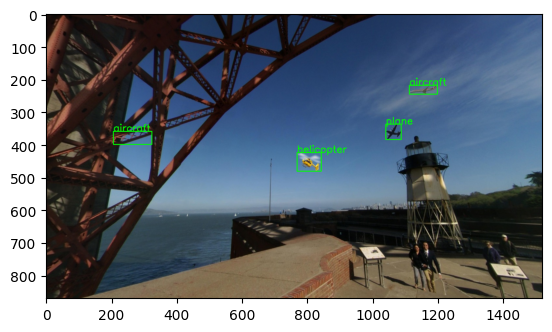

In [2]:
# deploy
model = YOLO("data/yolo/vlm_yolo/weights/best.pt", task = "deploy")
image = cv2.imread("vlm/example.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = model(image)
print(results[0].boxes.xyxy.cpu().numpy())
print(results[0].boxes.cls.cpu().numpy())
for box, cls in zip(results[0].boxes.xyxy.cpu().numpy(), results[0].boxes.cls.cpu().numpy()):
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    cv2.putText(image, model.names[int(cls)], (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(image)
plt.show()

In [4]:
model.train(
    data="data/yolo/dataset.yaml",
    epochs=20,
    batch=8,
    imgsz=640,
    device=0    ,
    save_period=10,
    project="data/yolo",
    name="vlm_yolo",
    exist_ok=True,
    verbose=True,
    seed=0,
    patience=10,
)
    


New https://pypi.org/project/ultralytics/8.2.15 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.14  Python-3.10.11 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov9c.pt, data=data/yolo/dataset.yaml, epochs=20, time=None, patience=10, batch=8, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=8, project=data/yolo, name=vlm_yolo, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None

c:\Users\zedon\Documents\GitHub\til-24-overflow\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 


train: Scanning C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\train.cache... 4085 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4085/4085 [00:00<?, ?it/s]
val: Scanning C:\Users\zedon\Documents\GitHub\til-24-overflow\data\yolo\labels\val.cache... 1022 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1022/1022 [00:00<?, ?it/s]


Plotting labels to data\yolo\vlm_yolo\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to data\yolo\vlm_yolo
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.91G     0.8755     0.5011     0.8356         63        640: 100%|██████████| 511/511 [02:45<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.42it/s]

                   all       1022       5702      0.962      0.935      0.976      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      6.07G     0.8975     0.4806      0.839         41        640: 100%|██████████| 511/511 [02:38<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.48it/s]

                   all       1022       5702      0.969      0.945      0.982      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.14G      0.912     0.4976     0.8414         40        640: 100%|██████████| 511/511 [02:37<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.47it/s]

                   all       1022       5702      0.957      0.931      0.975      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.07G     0.9123     0.4962     0.8415         61        640: 100%|██████████| 511/511 [02:36<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.38it/s]

                   all       1022       5702      0.965      0.925      0.976      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.14G     0.9129     0.4877     0.8408         24        640: 100%|██████████| 511/511 [02:36<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.44it/s]

                   all       1022       5702      0.972      0.934      0.978       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.15G     0.8958     0.4757     0.8387         61        640: 100%|██████████| 511/511 [02:36<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.45it/s]

                   all       1022       5702      0.948       0.93      0.976      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.14G     0.8884     0.4687     0.8378         35        640: 100%|██████████| 511/511 [02:36<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.41it/s]

                   all       1022       5702      0.969      0.943      0.982      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.14G     0.8882     0.4716     0.8366         50        640: 100%|██████████| 511/511 [02:35<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.42it/s]

                   all       1022       5702      0.966      0.949      0.984      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.14G     0.8792     0.4594     0.8356         45        640: 100%|██████████| 511/511 [02:36<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.48it/s]

                   all       1022       5702      0.978      0.946      0.985      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.11G     0.8729      0.451     0.8335         35        640: 100%|██████████| 511/511 [02:36<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.49it/s]

                   all       1022       5702      0.967      0.941       0.98      0.724


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.15G     0.8513     0.4178     0.8361         24        640: 100%|██████████| 511/511 [02:37<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:10<00:00,  6.33it/s]

                   all       1022       5702      0.973      0.941      0.981      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.07G     0.8328     0.4078     0.8319         26        640: 100%|██████████| 511/511 [02:48<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:12<00:00,  4.95it/s]

                   all       1022       5702      0.961      0.935      0.978      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.14G     0.8225     0.4061      0.829         27        640: 100%|██████████| 511/511 [02:50<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:13<00:00,  4.88it/s]

                   all       1022       5702      0.967      0.941      0.981      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.14G     0.8122     0.3948     0.8285         23        640: 100%|██████████| 511/511 [02:43<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:11<00:00,  5.78it/s]

                   all       1022       5702      0.972      0.941      0.983      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.14G      0.805     0.3848     0.8264         21        640: 100%|██████████| 511/511 [02:33<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.52it/s]

                   all       1022       5702       0.97      0.943      0.983      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.14G     0.8002     0.3801     0.8261         30        640: 100%|██████████| 511/511 [02:36<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.52it/s]

                   all       1022       5702      0.978      0.953      0.986      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.14G     0.7964     0.3744     0.8247         23        640: 100%|██████████| 511/511 [02:36<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.44it/s]

                   all       1022       5702      0.976      0.952      0.987      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.12G     0.7852     0.3648     0.8259         33        640: 100%|██████████| 511/511 [02:36<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.45it/s]

                   all       1022       5702      0.983      0.951      0.988      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.15G     0.7742     0.3552     0.8237         20        640: 100%|██████████| 511/511 [02:36<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.46it/s]

                   all       1022       5702      0.978      0.958       0.99      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.07G     0.7745     0.3524     0.8227         27        640: 100%|██████████| 511/511 [02:35<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.54it/s]

                   all       1022       5702      0.978      0.958      0.989      0.786



20 epochs completed in 0.949 hours.
Optimizer stripped from data\yolo\vlm_yolo\weights\last.pt, 51.6MB
Optimizer stripped from data\yolo\vlm_yolo\weights\best.pt, 51.6MB

Validating data\yolo\vlm_yolo\weights\best.pt...
Ultralytics YOLOv8.2.14  Python-3.10.11 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv9c summary (fused): 384 layers, 25323874 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:09<00:00,  6.46it/s]


                   all       1022       5702      0.978      0.959       0.99      0.787
                   jet       1022        851      0.992      0.927       0.99      0.789
              aircraft       1022       1672      0.974      0.974       0.99      0.817
                 drone       1022        389      0.954      0.964      0.986      0.771
               missile       1022        592      0.984      0.958      0.989      0.789
            helicopter       1022       1091      0.979      0.973      0.992      0.762
                 plane       1022       1107      0.983      0.956       0.99      0.796
Speed: 0.2ms preprocess, 6.3ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to data\yolo\vlm_yolo


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000019A4A569600>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
 

In [ ]:
# save model to disk
model.save("data/yolo/vlm_yolo/weights/best.pt")